<div>

> **Note**
>
> Code chunks run Python commands unless it starts with `%%bash`, in
> which case, those chunks run shell commands.

</div>

## Get data

In this tutorial, we will run all tutorials with a set of 8 PBMC 10x
datasets from 4 covid-19 patients and 4 healthy controls, the samples
have been subsampled to 1500 cells per sample. We can start by defining
our paths.

In [15]:
#| label: paths

import os

path_data = "https://nextcloud.dc.scilifelab.se/public.php/webdav"
curl_upass = "zbC5fr2LbEZ9rSE:scRNAseq2025"

path_covid = "./data/covid/raw"
if not os.path.exists(path_covid):
    os.makedirs(path_covid, exist_ok=True)

path_results = "data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

In [16]:
#| label: fetch-data
import subprocess

file_list = [
    "normal_pbmc_13.h5", "normal_pbmc_14.h5", "normal_pbmc_19.h5", "normal_pbmc_5.h5",
    "ncov_pbmc_15.h5", "ncov_pbmc_16.h5", "ncov_pbmc_17.h5", "ncov_pbmc_1.h5"
]

for i in file_list:
    path_file = os.path.join(path_covid, i)
    if not os.path.exists(path_file):
        file_url = os.path.join(path_data, "covid/raw", i)
        subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3495k  100 3495k    0     0   331k      0  0:00:10  0:00:10 --:--:--  821k


With data in place, now we can start loading libraries we will use in
this tutorial.

In [17]:
#| label: libraries
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
import gc

warnings.simplefilter(action='ignore', category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

We can first load the data individually by reading directly from HDF5
file format (.h5).

In Scanpy we read them into an Anndata object with the the function
`read_10x_h5`

In [18]:
#| label: read-data

data_cov1 = sc.read_10x_h5(os.path.join(path_covid,'ncov_pbmc_1.h5'))
data_cov1.var_names_make_unique()
data_cov15 = sc.read_10x_h5(os.path.join(path_covid,'ncov_pbmc_15.h5'))
data_cov15.var_names_make_unique()
data_cov16 = sc.read_10x_h5(os.path.join(path_covid,'ncov_pbmc_16.h5'))
data_cov16.var_names_make_unique()
data_cov17 = sc.read_10x_h5(os.path.join(path_covid,'ncov_pbmc_17.h5'))
data_cov17.var_names_make_unique()
data_ctrl5 = sc.read_10x_h5(os.path.join(path_covid,'normal_pbmc_5.h5'))
data_ctrl5.var_names_make_unique()
data_ctrl13 = sc.read_10x_h5(os.path.join(path_covid,'normal_pbmc_13.h5'))
data_ctrl13.var_names_make_unique()
data_ctrl14 = sc.read_10x_h5(os.path.join(path_covid,'normal_pbmc_14.h5'))
data_ctrl14.var_names_make_unique()
data_ctrl19 = sc.read_10x_h5(os.path.join(path_covid,'normal_pbmc_19.h5'))
data_ctrl19.var_names_make_unique()

reading ./data/covid/raw/ncov_pbmc_1.h5
 (0:00:00)
reading ./data/covid/raw/ncov_pbmc_15.h5
 (0:00:00)
reading ./data/covid/raw/ncov_pbmc_16.h5
 (0:00:00)
reading ./data/covid/raw/ncov_pbmc_17.h5
 (0:00:00)
reading ./data/covid/raw/normal_pbmc_5.h5
 (0:00:00)
reading ./data/covid/raw/normal_pbmc_13.h5
 (0:00:00)
reading ./data/covid/raw/normal_pbmc_14.h5
 (0:00:00)
reading ./data/covid/raw/normal_pbmc_19.h5
 (0:00:00)


## Collate

We can now merge them objects into a single object. Each analysis
workflow (Seurat, Scater, Scanpy, etc) has its own way of storing data.
We will add dataset labels as **cell.ids** just in case you have
overlapping barcodes between the datasets. After that we add a column
**type** in the metadata to define covid and ctrl samples.

In [19]:
#| label: metadata

# add some metadata
data_cov1.obs['type']="Covid"
data_cov1.obs['sample']="covid_1"
data_cov15.obs['type']="Covid"
data_cov15.obs['sample']="covid_15"
data_cov16.obs['type']="Covid"
data_cov16.obs['sample']="covid_16"
data_cov17.obs['type']="Covid"
data_cov17.obs['sample']="covid_17"
data_ctrl5.obs['type']="Ctrl"
data_ctrl5.obs['sample']="ctrl_5"
data_ctrl13.obs['type']="Ctrl"
data_ctrl13.obs['sample']="ctrl_13"
data_ctrl14.obs['type']="Ctrl"
data_ctrl14.obs['sample']="ctrl_14"
data_ctrl19.obs['type']="Ctrl"
data_ctrl19.obs['sample']="ctrl_19"

# merge into one object.
adata = data_cov1.concatenate(data_cov15, data_cov16, data_cov17, data_ctrl5, data_ctrl13, data_ctrl14, data_ctrl19)

# and delete individual datasets to save space
del(data_cov1, data_cov15, data_cov16, data_cov17)
del(data_ctrl5, data_ctrl13, data_ctrl14, data_ctrl19)
gc.collect()

1325

You can print a summary of the datasets in the Scanpy object, or a
summary of the whole object.

In [20]:
#| label: show-object

print(adata.obs['sample'].value_counts())
adata

sample
covid_1     1500
covid_15    1500
covid_16    1500
covid_17    1500
ctrl_5      1500
ctrl_13     1500
ctrl_14     1500
ctrl_19     1500
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 12000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

## Calculate QC

Having the data in a suitable format, we can start calculating some
quality metrics. We can for example calculate the percentage of
mitochondrial and ribosomal genes per cell and add to the metadata. The
proportion of hemoglobin genes can give an indication of red blood cell
contamination, but in some tissues it can also be the case that some
celltypes have higher content of hemoglobin. This will be helpful to
visualize them across different metadata parameters (i.e. datasetID and
chemistry version). There are several ways of doing this. The QC metrics
are finally added to the metadata table.

Citing from Simple Single Cell workflows (Lun, McCarthy & Marioni,
2017): High proportions are indicative of poor-quality cells (Islam et
al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic
RNA from perforated cells. The reasoning is that mitochondria are larger
than individual transcript molecules and less likely to escape through
tears in the cell membrane.

First, let Scanpy calculate some general qc-stats for genes and cells
with the function `sc.pp.calculate_qc_metrics`, similar to
`calculateQCmetrics()` in Scater. It can also calculate proportion of
counts for specific gene populations, so first we need to define which
genes are mitochondrial, ribosomal and hemoglobin.

In [21]:
#| label: qc-genes
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P|E|S)]"))

adata.var

,gene_ids,feature_types,genome,mt,ribo,hb
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False
...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,False,False
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,False,False
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,False,False
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,False,False


In [22]:
#| label: qc-calc
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

Now you can see that we have additional data in the metadata slot.

Another opition to using the `calculate_qc_metrics` function is to
calculate the values on your own and add to a metadata slot. An example
for mito genes can be found below:

In [23]:
#| label: qc-calc-custom

mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata

AnnData object with n_obs × n_vars = 12000 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Plot QC

Now we can plot some of the QC variables as violin plots.

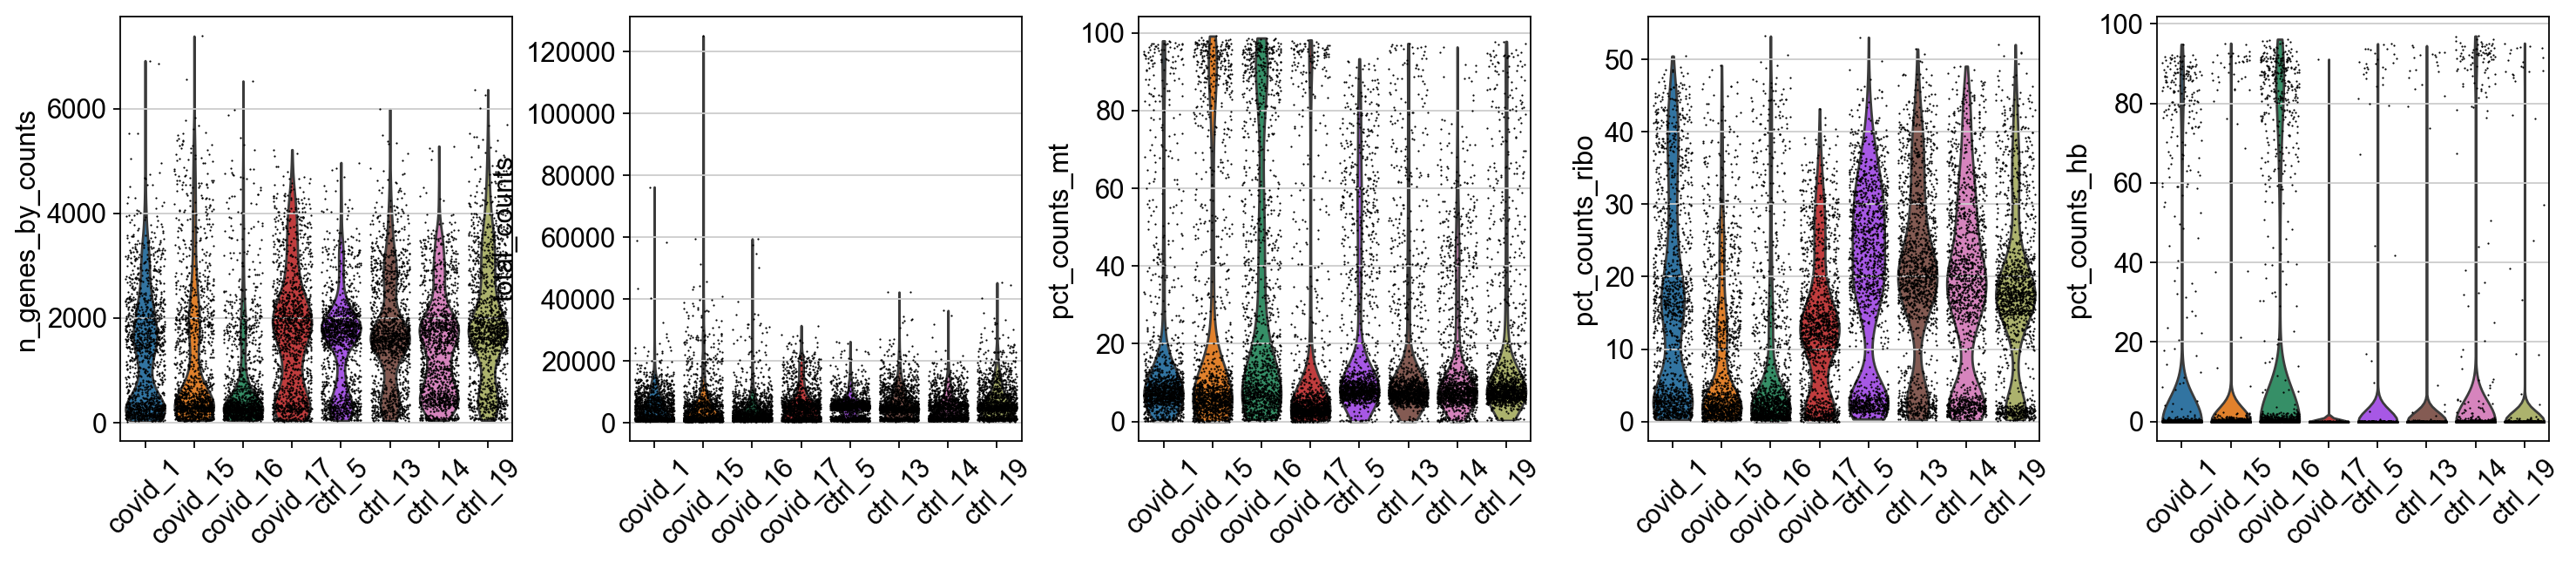

In [24]:
#| label: qc-vln

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, groupby = 'sample', rotation= 45)

<div>

> **Discuss**
>
> Looking at the violin plots, what do you think are appropriate cutoffs
> for filtering these samples

</div>

As you can see, there is quite some difference in quality for these
samples, with for instance the covid_15 and covid_16 samples having
cells with fewer detected genes and more mitochondrial content. As the
ribosomal proteins are highly expressed they will make up a larger
proportion of the transcriptional landscape when fewer of the lowly
expressed genes are detected. We can also plot the different QC-measures
as scatter plots.

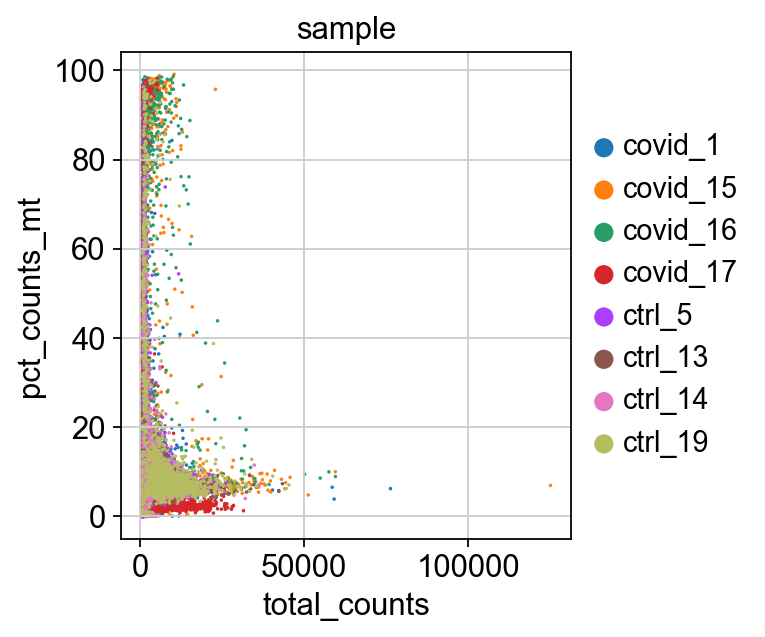

In [25]:
#| label: qc-scatter
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")

<div>

> **Discuss**
>
> Plot additional QC stats that we have calculated as scatter plots. How
> are the different measures correlated? Can you explain why?

</div>

## Filtering

### Detection-based filtering

A standard approach is to filter cells with low number of reads as well
as genes that are present in at least a given number of cells. Here we
will only consider cells with at least 200 detected genes and genes need
to be expressed in at least 3 cells. Please note that those values are
highly dependent on the library preparation method used.

In [26]:
#| label: filter1

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 1336 cells that have less than 200 genes expressed
filtered out 14047 genes that are detected in less than 3 cells
10664 19491


Extremely high number of detected genes could indicate doublets.
However, depending on the cell type composition in your sample, you may
have cells with higher number of genes (and also higher counts) from one
cell type. In this case, we will run doublet prediction further down, so
we will skip this step now, but the code below is an example of how it
can be run:

In [27]:
#| label: filter-detection

# skip for now as we are doing doublet prediction
#keep_v2 = (adata.obs['n_genes_by_counts'] < 2000) & (adata.obs['n_genes_by_counts'] > 500) & (adata.obs['lib_prep'] == 'v2')
#print(sum(keep_v2))

# filter for gene detection for v3
#keep_v3 = (adata.obs['n_genes_by_counts'] < 4100) & (adata.obs['n_genes_by_counts'] > 1000) & (adata.obs['lib_prep'] != 'v2')
#print(sum(keep_v3))

# keep both sets of cells
#keep = (keep_v2) | (keep_v3)
#print(sum(keep))
#adata = adata[keep, :]

#print("Remaining cells %d"%adata.n_obs)

Additionally, we can also see which genes contribute the most to such
reads. We can for instance plot the percentage of counts per gene.

normalizing counts per cell
    finished (0:00:00)


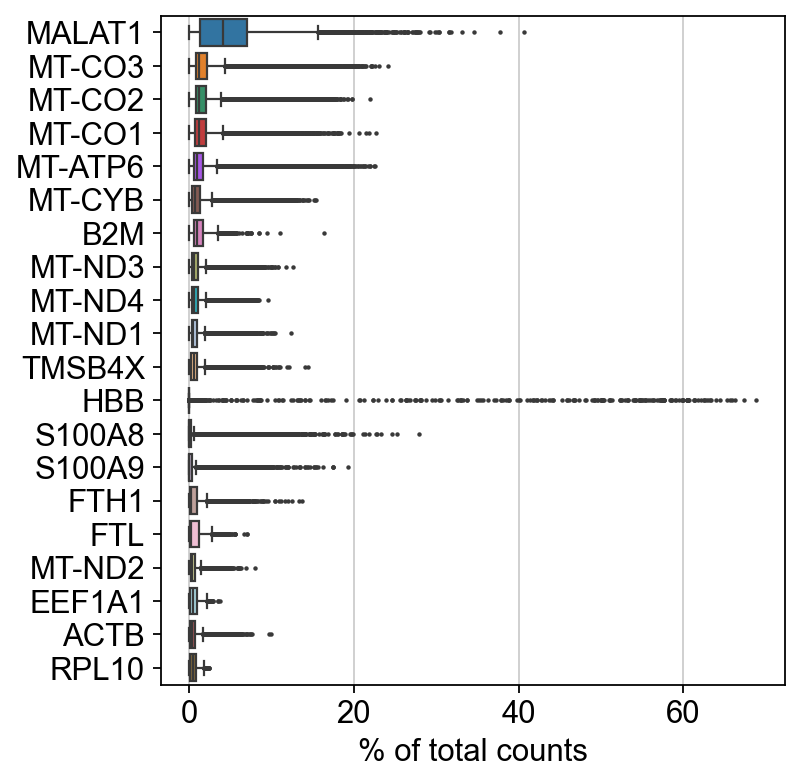

In [28]:
#| label: top-genes
sc.pl.highest_expr_genes(adata, n_top=20)

As you can see, MALAT1 constitutes up to 30% of the UMIs from a single
cell and the other top genes are mitochondrial and ribosomal genes. It
is quite common that nuclear lincRNAs have correlation with quality and
mitochondrial reads, so high detection of MALAT1 may be a technical
issue. Let us assemble some information about such genes, which are
important for quality control and downstream filtering.

### Mito/Ribo filtering

We also have quite a lot of cells with high proportion of mitochondrial
and low proportion of ribosomal reads. It would be wise to remove those
cells, if we have enough cells left after filtering. Another option
would be to either remove all mitochondrial reads from the dataset and
hope that the remaining genes still have enough biological signal. A
third option would be to just regress out the `percent_mito` variable
during scaling. In this case we had as much as 99.7% mitochondrial reads
in some of the cells, so it is quite unlikely that there is much cell
type signature left in those. Looking at the plots, make reasonable
decisions on where to draw the cutoff. In this case, the bulk of the
cells are below 20% mitochondrial reads and that will be used as a
cutoff. We will also remove cells with less than 5% ribosomal reads.

In [29]:
#| label: filter2
# filter for percent mito
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 7431


As you can see, a large proportion of sample covid_15 is filtered out.
Also, there is still quite a lot of variation in `percent_mito`, so it
will have to be dealt with in the data analysis step. We can also notice
that the `percent_ribo` are also highly variable, but that is expected
since different cell types have different proportions of ribosomal
content, according to their function.

### Plot filtered QC

Lets plot the same QC-stats once more.

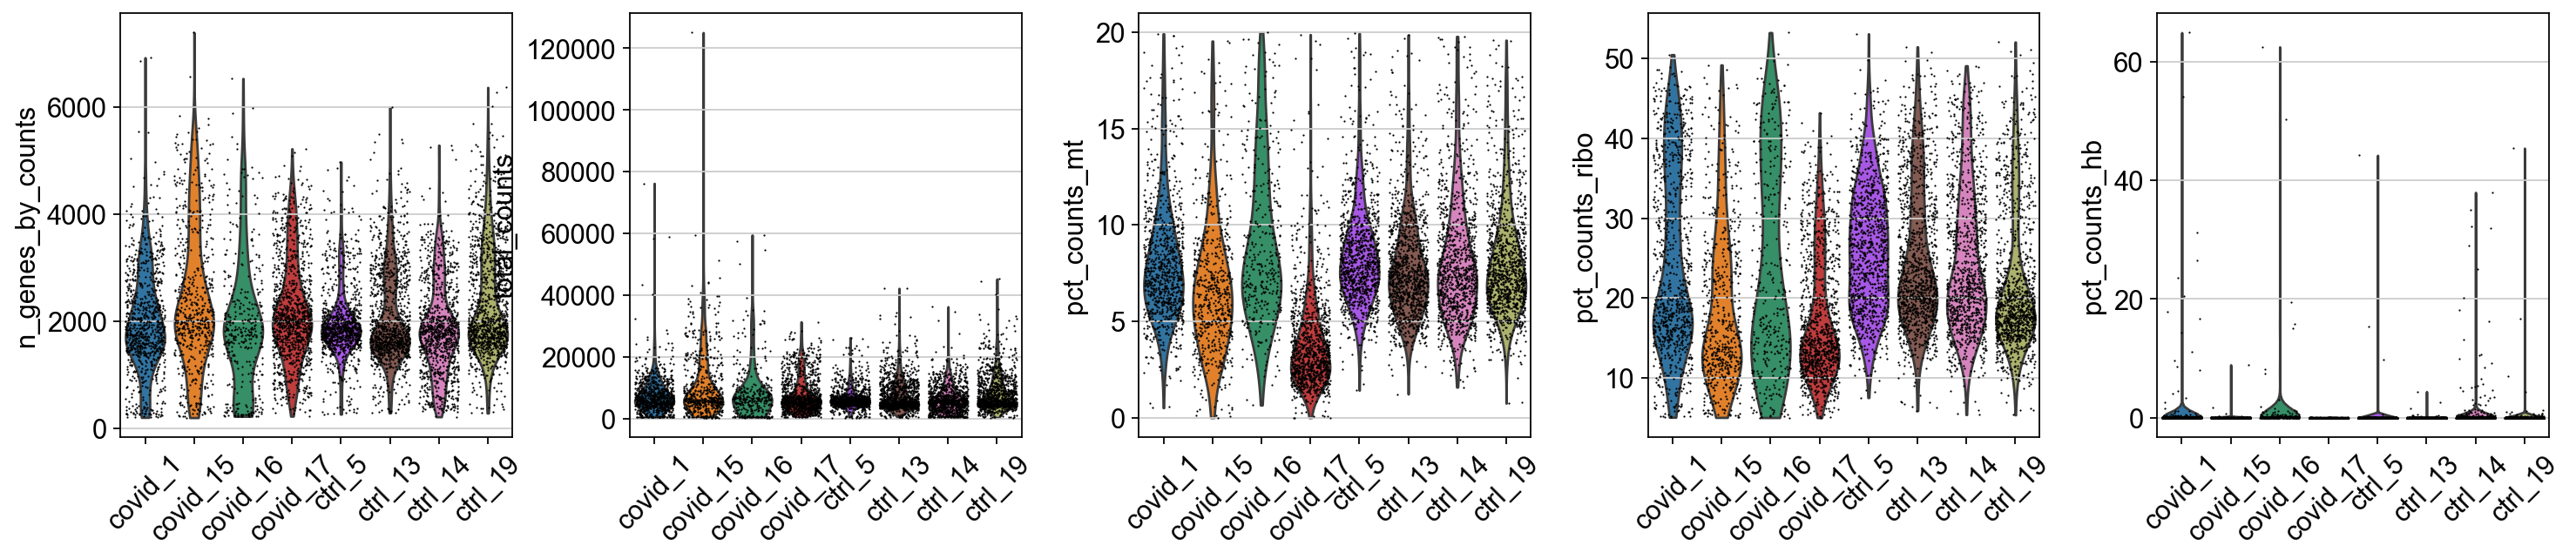

In [30]:
#| label: qc-vln2
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, groupby = 'sample', rotation = 45)

### Filter genes

As the level of expression of mitochondrial and MALAT1 genes are judged
as mainly technical, it can be wise to remove them from the dataset
before any further analysis. In this case we will also remove the HB
genes.

In [31]:
#| label: filter-genes
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P|E|S)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

7431 19468


## Sample sex

When working with human or animal samples, you should ideally constrain
your experiments to a single sex to avoid including sex bias in the
conclusions. However this may not always be possible. By looking at
reads from chromosomeY (males) and XIST (X-inactive specific transcript)
expression (mainly female) it is quite easy to determine per sample
which sex it is. It can also be a good way to detect if there has been
any mislabelling in which case, the sample metadata sex does not agree
with the computational predictions.

To get choromosome information for all genes, you should ideally parse
the information from the gtf file that you used in the mapping pipeline
as it has the exact same annotation version/gene naming. However, it may
not always be available, as in this case where we have downloaded public
data. Hence, we will use biomart to fetch chromosome information.

In [33]:
#| label: fetch-annot
# requires pybiomart

annot_file = 'data/covid/results/gene_annotations_pybiomart.csv'

if not os.path.exists(annot_file):
    annot = sc.queries.biomart_annotations("hsapiens", ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"] ).set_index("external_gene_name")
    annot.to_csv(annot_file)
else:
    annot = pd.read_csv(annot_file, index_col=0)

Now that we have the chromosome information, we can calculate the
proportion of reads that comes from chromosome Y per cell.But first we
have to remove all genes in the pseudoautosmal regions of chrY that are:
\* chromosome:GRCh38:Y:10001 - 2781479 is shared with X: 10001 - 2781479
(PAR1) \* chromosome:GRCh38:Y:56887903 - 57217415 is shared with X:
155701383 - 156030895 (PAR2)

In [ ]:
#| label: par
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

par1 = [10001, 2781479]
par2 = [56887903, 57217415]

par1_genes = annot.index[(annot.chromosome_name == "Y") & (annot.start_position > par1[0]) & (annot.start_position < par1[1]) ]

par2_genes = annot.index[(annot.chromosome_name == "Y") & (annot.start_position > par2[0]) & (annot.start_position < par2[1]) ]

chrY_genes = chrY_genes.difference(par1_genes)
chrY_genes = chrY_genes.difference(par2_genes)

adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

Then plot XIST expression vs chrY proportion. As you can see, the
samples are clearly on either side, even if some cells do not have
detection of either.

In [ ]:
#| label: sex-scatter

# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample")

Plot as violins.

In [ ]:
#| label: sex-vln

sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby = 'sample', rotation= 45)

Here, we can see clearly that we have three males and five females, can
you see which samples they are? Do you think this will cause any
problems for downstream analysis? Discuss with your group: what would be
the best way to deal with this type of sex bias?

## Cell cycle state

We here perform cell cycle scoring. To score a gene list, the algorithm
calculates the difference of mean expression of the given list and the
mean expression of reference genes. To build the reference, the function
randomly chooses a bunch of genes matching the distribution of the
expression of the given list. Cell cycle scoring adds three slots in the
metadata, a score for S phase, a score for G2M phase and the predicted
cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into
S and G2M phase genes. We first download the file.

In [34]:
#| label: fetch-ccgenes
path_file = os.path.join(path_results, 'regev_lab_cell_cycle_genes.txt')
if not os.path.exists(path_file):
    file_url = os.path.join(path_data, "misc/regev_lab_cell_cycle_genes.txt")
    subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   556  100   556    0     0    226      0  0:00:02  0:00:02 --:--:--   226


In [35]:
#| label: prep-ccgenes
cell_cycle_genes = [x.strip() for x in open('./data/covid/results/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


Before running cell cycle we have to normalize the data. In the scanpy
object, the data slot will be overwritten with the normalized data. So
first, save the raw data into the slot `raw`. Then run normalization,
log transformation and scale the data.

In [36]:
#| label: normalize
# save raw counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_total(adata, target_sum=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


We here perform cell cycle scoring. The function is actually a wrapper
to sc.tl.score_gene_list, which is launched twice, to score separately S
and G2M phases. Both sc.tl.score_gene_list and
sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to
work in a very similar way. To score a gene list, the algorithm
calculates the difference of mean expression of the given list and the
mean expression of reference genes. To build the reference, the function
randomly chooses a bunch of genes matching the distribution of the
expression of the given list. Cell cycle scoring adds three slots in
data, a score for S phase, a score for G2M phase and the predicted cell
cycle phase.

In [37]:
#| label: cc
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    688 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


We can now create a violin plot for the cell cycle scores as well.

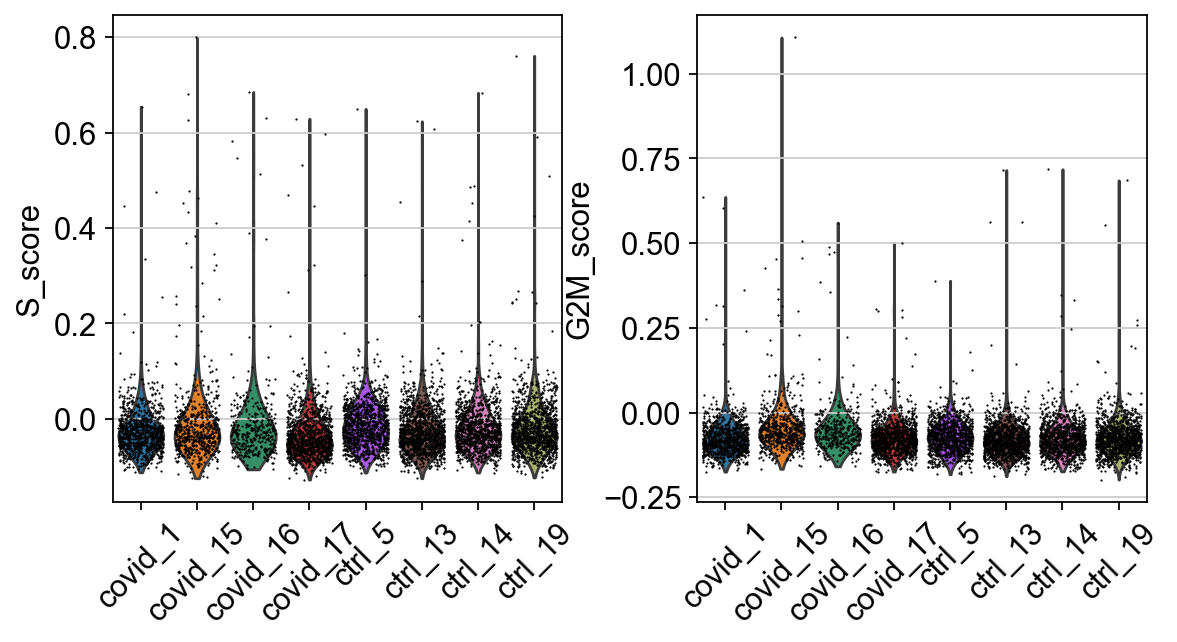

In [38]:
#| label: cc-vln

sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'sample', rotation=45)

In this case it looks like we only have a few cycling cells in these
datasets.

Scanpy does an automatic prediction of cell cycle phase with a default
cutoff of the scores at zero. As you can see this does not fit this data
very well, so be cautios with using these predictions. Instead we
suggest that you look at the scores.

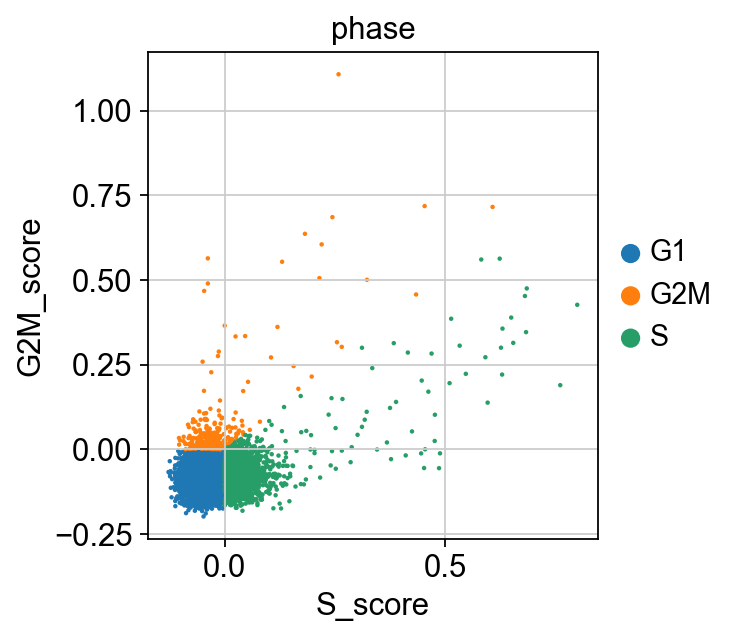

In [39]:
#| label: cc-scatter

sc.pl.scatter(adata, x='S_score', y='G2M_score', color="phase")

## Predict doublets

Doublets/Multiples of cells in the same well/droplet is a common issue
in scRNAseq protocols. Especially in droplet-based methods with
overloading of cells. In a typical 10x experiment the proportion of
doublets is linearly dependent on the amount of loaded cells. As
indicated from the Chromium user guide, doublet rates are about as
follows:\
![](../figs/10x_doublet_rate.png)\
Most doublet detectors simulates doublets by merging cell counts and
predicts doublets as cells that have similar embeddings as the simulated
doublets. Most such packages need an assumption about the
number/proportion of expected doublets in the dataset. The data you are
using is subsampled, but the original datasets contained about 5 000
cells per sample, hence we can assume that they loaded about 9 000 cells
and should have a doublet rate at about 4%.

For doublet detection, we will use the package `Scrublet`, so first we
need to get the raw counts from `adata.raw.X` and run scrublet with that
matrix. Then we add in the doublet prediction info into our anndata
object.

Doublet prediction should be run for each dataset separately, so first
we need to split the adata object into 6 separate objects, one per
sample and then run scrublet on each of them.

In [49]:
#| label: doublet
import scrublet as scr

# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    tmp = adata[adata.obs['sample'] == batch,]
    print(batch, ":", tmp.shape[0], " cells")
    scrub = scr.Scrublet(tmp.raw.X)
    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)
    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
    print(alldata[batch].predicted_doublets.sum(), " predicted_doublets")

In [52]:
alldata

{}

In [50]:
# add predictions to the adata object.
scrub_pred = pd.concat(alldata.values())
adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 

# sum(adata.obs['predicted_doublets'])

ValueError: No objects to concatenate

We should expect that two cells have more detected genes than a single
cell, lets check if our predicted doublets also have more detected genes
in general.

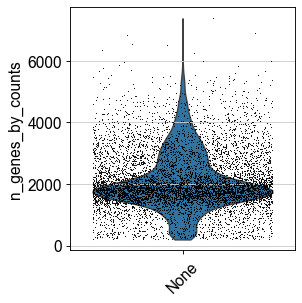

In [45]:
#| label: plot-doublet

# add in column with singlet/doublet instead of True/Fals
%matplotlib inline

adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, groupby = 'doublet_info', rotation=45)

Now, lets run PCA and UMAP and plot doublet scores onto UMAP to check
the doublet predictions. We will go through these steps in more detail
in the later exercises.

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


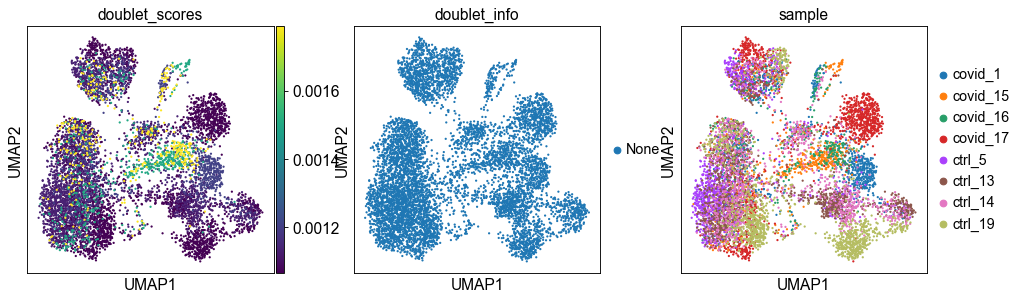

In [46]:
#| label: doublet-umap

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['doublet_scores','doublet_info','sample'])

Now, lets remove all predicted doublets from our data.

In [47]:
#| label: doublet-filt
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(0, 19468)


To summarize, lets check how many cells we have removed per sample, we
started with 1500 cells per sample. Looking back at the intitial QC
plots does it make sense that some samples have much fewer cells now?

``` {r}
#| label: view-data
adata.obs["sample"].value_counts()
```

<div>

> **Discuss**
>
> "In this case we ran doublet detection with all samples together since
> we have very small subsampled datasets. But in a real scenario it
> should be run one sample at a time. Why is this important do you
> think?"

</div>

## Save data

Finally, lets save the QC-filtered data for further analysis. Create
output directory `data/covid/results` and save data to that folder. This
will be used in downstream labs.

In [ ]:
#| label: save
adata.write_h5ad('data/covid/results/scanpy_covid_qc.h5ad')

## Session info

```{=html}
<details>
```
```{=html}
<summary>
```
Click here
```{=html}
</summary>
```

In [ ]:
#| label: session
sc.logging.print_versions()

```{=html}
</details>
```